<a href="https://colab.research.google.com/github/mpv88/DeepLearning2022/blob/main/Second_assignment_11122022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lorenzobasile/DeepLearning2022/blob/main/5_autoencoder.ipynb)

#Second assignment - 12/2022 - *mattia pividori (s284690)*
---


##Instructions:
1. Compute the Intrinsic Dimension of KMNIST dataset using [TwoNN](https://www.nature.com/articles/s41598-017-11873-y). There is no need to implement TwoNN from scratch: you can use the implementation in the [`dadapy package`](https://dadapy.readthedocs.io/en/latest/jupyter_example_3.html), which you can install via `pip install dadapy`.
2. Build a Convolutional Autoencoder to reduce the dimensionality of KMNIST to a value $d$ that is compatible with the ID estimate you found in step 1. Once you have trained the model (until you notice some stability in the loss, likely not before 20 epochs of training), plot some examples of reconstructed images to qualitatively assess how well the model is performing.
3. If the encoder is performing sufficiently well, you should be able to perform almost any task of your choice on the original data by only looking at the internal hidden representations that it extracts. To see if this is the case, build a new model made of the encoder you have already trained (freezed) and a classification head (a trainable fully connected layer with `in_features=d` and `ou_features=10`). Train this new model for classification and assess the final accuracy. Don't expect perfect accuracy: anything substantially higher than random classification is fine.
4. As pointed out by prof. Ansuini during the lab, it may be interesting to visualize the representations that your Autoencoder learns while training. Since your hidden dimension $d$ will likely be much higher than 2 or 3, it would be impossible to simply plot the representations and see where they end up being. To visualize them, you could use another dimensionality reduction technique on top of your Encoder, such as t-SNE, to further reduce your $d$ features to 2 or 3, just like what is shown for example in this nice [github repo](https://github.com/ncampost/vis-autoencoder-tsne) and in this great [lecture](https://atcold.github.io/NYU-DLSP21/en/week09/09-3/) by Alfredo Canziani, which is also a good reference to study Autoencoders in general.

First we install the DADApy python package, useful for distance-based analysis of data-manifolds.

In [1]:
# source @https://dadapy.readthedocs.io/en/latest
!pip install dadapy # install dadapy 0.1.1

#!pip list # check installed packages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 243 kB 5.1 MB/s 
  Created wheel for dadapy: filename=dadapy-0.1.1-cp38-cp38-linux_x86_64.whl size=529426 sha256=c31dff33acdd8bf7fd069c6750fdea1b52234324cb06df71846723a0f3fefcf5
  Stored in directory: /root/.cache/pip/wheels/9a/3c/b5/bf6da4cd003d70455f49779b4806528f181fec147c459c6e3f
Successfully built dadapy


Next we import the required Python libraries, as usual also fixing a seed for reproducibility of our results and enabling the loading/saving inputs or outputs from/to the Drive. We also setup the 'device' variable, helpful to allow us running easily our analysis on both GPU hardware accelerator or CPU support. 

In [2]:
import dadapy
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/DeepLearning2022

Mounted at /content/drive
/content/drive/MyDrive/DeepLearning2022


In [3]:
# set general purpose parameters

btc_size = 1000

seed = 1234
torch.manual_seed(seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # run on gpu or cpu

Below, we load the kMNIST dataset (handwritten Kanji characters belonging to 10 classes) whose images are in greyscale, we store it into tensors and we normalize raw data. Finally we load all to the Dataloader utility, and we divide them into a train and test set, unpacking images from their labels and enabling their data structures to be run equivalently with or without GPU support.

In [4]:
# import kMNIST dataset

# import data and normalize them, storing on a Tensor
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])

# slice the overall dataset into a train and a test set
k_trainset = torchvision.datasets.KMNIST('./data/', transform=transforms,  train=True, download=True)
k_testset = torchvision.datasets.KMNIST('./data/', transform=transforms, train=False, download=True)

# pass train and test set to dataloaders
k_trainloader = torch.utils.data.DataLoader(k_trainset, batch_size=btc_size, shuffle=True)
k_testloader = torch.utils.data.DataLoader(k_testset, batch_size=btc_size, shuffle=False)

# unpack X and y
images, labels = next(iter(k_trainloader))
images, labels = images.to(device), labels.to(device) # enables running on GPU

Just a quick look to a random image part of the dataset and to its features, to allow a better understanding of which would be the required steps to perform.

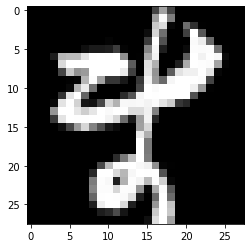

In [5]:
# check dataset general characteristics

# peek sample image of our datset
first_img = images[0]
plt.imshow(first_img.cpu().reshape(28,28), cmap='gray')

Here we proceed computing the Intrinsic Dimension (ID) estimate on our Kmnist dataset using the TwoNN estimator. We then round its value to the closest integer and assign it to the $d$ variable which represents the intrinsic dimensions of the manifold data, so the minimum number of coordinates needed to describe the manifold without significant losses in the information. We find a value for $d$ of circa 17 for the chosen size of our batches.

In [6]:
# Intrinsic Dimension (ID) computation

# reshape from tensor to numpy (batch, height x width)=(256, 28x28) array
np_images = np.reshape(np.squeeze(images.cpu()), (btc_size, -1)).numpy()

# initialise the "Data" class with a set of coordinates for our dataset
data = dadapy.data.Data(np_images)

# compute ID using the 2NN estimator
ID, err, _ = data.compute_id_2NN(decimation=1.) # uses entire train set

# check the value of ID found
print(data.intrinsic_dim)  # ID≈16.91

# set target dimension to an integer for later use
d = round(data.intrinsic_dim)

16.91550040012337


We next build our AutoEncoder neural model made of a first encoder chunck, which maps the input into a latent representation on a lower-dimensional space, and a second decoder chunck, which symmetrically goes in the sense of reconstructing an image in the original space starting from its low-dimensional representation. The details on the structure used follow: 

Encoder layer:
1. Convolutional layer with 32 filters, kernel size=3, stride=1, padding=0
2. Max pooling layer with kernel size=2
3. Convolutional layer with 64 filters, kernel size=3, stride=2, padding=1
4. Max pooling layer with kernel size=2, stride=1
5. Flattening layer
6. Linear layer with input size=6x6x64, output size=d
7. ReLU activations wherever needed

Decoder layer:
1. Linear layer with input size=d, output size=64x8x8
2. Unflattening layer to obtain [64x8x8] data
3. Transpose Convolution with 32 filters, kernel size=2, stride=2, padding=1
4. Transpose Convolution with 1 filter, kernel size=2, stride=2, padding=0
5. ReLU activations wherever needed

Notice that the forward step returns both the encoded and the decoded versions of the original input image, so to allow viewing on both an intermediate version and the final result of the transformations made by our class.

In [7]:
# setup Convolutional Autoencoder (AE) class

class AutoEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2),
        torch.nn.Dropout(p=0.2),
        torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=1),
        torch.nn.Flatten(),
        torch.nn.Linear(64*6*6, d))
    
    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(d, 64*8*8),
        torch.nn.ReLU(),
        torch.nn.Unflatten(1, torch.Size([64, 8, 8])),
        torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, padding=1),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2, padding=0),
        torch.nn.Sigmoid()) # final pixels must be between 0 and 1
  
  def forward(self, X):
    encoded = self.encoder(X)
    decoded = self.decoder(encoded)
    return encoded, decoded

Within the next cell, besides initializing our AE model, we define the last three elements before proceeding with the training:

* the loss function: as the training of our autoencoder corresponds to regress output on input, our choice fell on the MSE Loss (see https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html).
* the optimizer: we decided to use the Adam algorithm, a method for stochastic optimization which is a combination of two gradient descent methods (Momentum and RMSP). It makes use of the average of the 2nd moments of the gradients calculating the exponential moving average of gradients and square gradients with parameters (β1 and β2) used to control the decay rates of moving averages. (see https://pytorch.org/docs/stable/generated/torch.optim.Adam.html). We left the learning rate parameter equal to the default value.
* the number of epochs for the training: after having tried many different lengths, we set for 30 epochs as it seemed as a balanced trade-off between the time required for training and the final (quite stable) level of training loss.


In [8]:
# initialize model, optimizer, loss, epochs for our autoencoder model

ae_model = AutoEncoder().to(device) # load model to the GPU
ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-3)
mse_loss = torch.nn.MSELoss(reduction='sum') # MSE as loss
n_epochs = 30

In the cell below we define our iterative training function which loops over data, with a first forward pass leading to a first guess of the output (i.e. X_hat), followed by the calculation of the loss and the cancellation of past gradients and their re-calculation by means of a backward step, so to result in an update of model's parameters (Θ).


In [9]:
# define a training function for a generic autoencoder

def ae_train(model, optimizer, loss_fn, trainloader, testloader, epochs):
  for epoch in range(epochs):
    model.train()
    train_loss = 0

    for X, y in iter(trainloader):
      X = X.to(device)
      X_encoded, X_hat = model(X)
      loss = loss_fn(X_hat, X)
      train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
    print("Epoch " + str(epoch+1) + " training loss:" + str(train_loss/(len(trainloader.dataset))))


Then we launch the effective training step, simply applying the function defined above.

In [10]:
# launch our autoencoder model training

ae_train(ae_model, ae_optimizer, mse_loss, k_trainloader, k_testloader, n_epochs) # final loss is about 562

Epoch 1 training loss:896.6895239583333
Epoch 2 training loss:701.05103125
Epoch 3 training loss:644.4275041666667
Epoch 4 training loss:621.8208354166667
Epoch 5 training loss:610.807146875
Epoch 6 training loss:603.50161875
Epoch 7 training loss:598.0173958333334
Epoch 8 training loss:592.8576927083334
Epoch 9 training loss:589.17269375
Epoch 10 training loss:586.3395864583333
Epoch 11 training loss:583.8495208333334
Epoch 12 training loss:581.702915625
Epoch 13 training loss:579.7072552083333
Epoch 14 training loss:577.887071875
Epoch 15 training loss:576.4837239583334
Epoch 16 training loss:574.3038125
Epoch 17 training loss:572.9507
Epoch 18 training loss:572.143275
Epoch 19 training loss:570.831615625
Epoch 20 training loss:569.5739666666667
Epoch 21 training loss:568.6497697916667
Epoch 22 training loss:567.7986270833334
Epoch 23 training loss:567.012325
Epoch 24 training loss:566.1951010416667
Epoch 25 training loss:565.4536458333333
Epoch 26 training loss:564.761921875
Epoch 2

The following function intends to compare some of the images present within the test set together with their recontructions made by the AutoEncoder, it does so by means of plotting some examples, in order to allow for a qualitative assessment how model's performance.

In [11]:
# define an image-reconstruction function to assess model performance

def display_images(input, output):
  if input is not None:
    input_pics = input.data.cpu().numpy().transpose((0, 2, 3, 1))
    plt.figure(figsize=(18, 4))
    for i in range(4):
      plt.subplot(1, 4, i+1)
      plt.imshow(np.squeeze(input_pics[i]))
      plt.figure(figsize=(18, 4))
      output_pics = output.data.cpu().numpy().transpose((0, 2, 3, 1))
      for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(np.squeeze(output_pics[i]))

Here we apply the previously defined function on our test set, obtaining as a result a value for our test loss (not so much higher than the train loss), plus the reproduction of original images paired with their reconstructed version, which enables a visual inspection of the goodness of model's reconstructions.

Test set loss:567.36630625


<ipython-input-11-34347da89524>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 4, i+1)


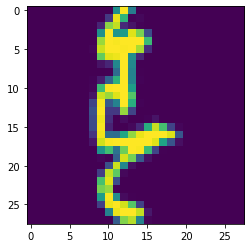

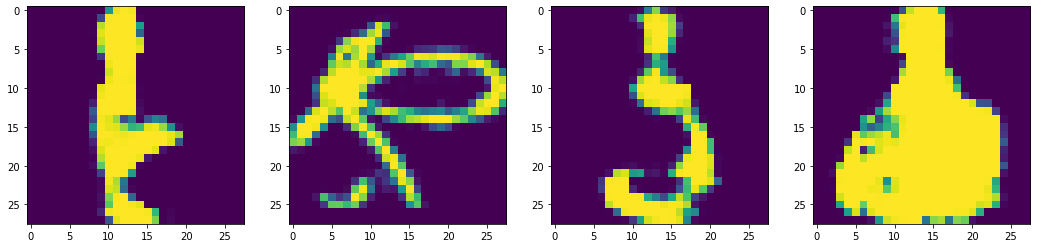

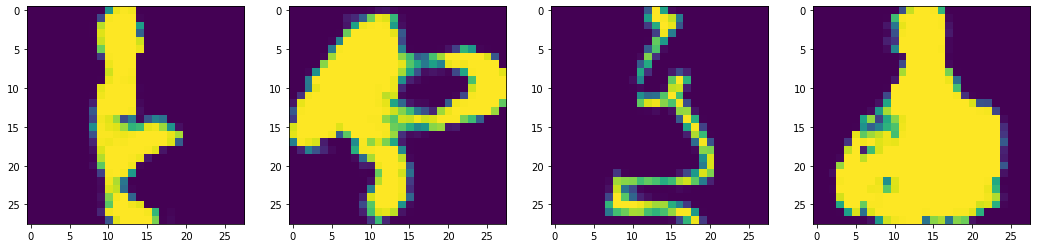

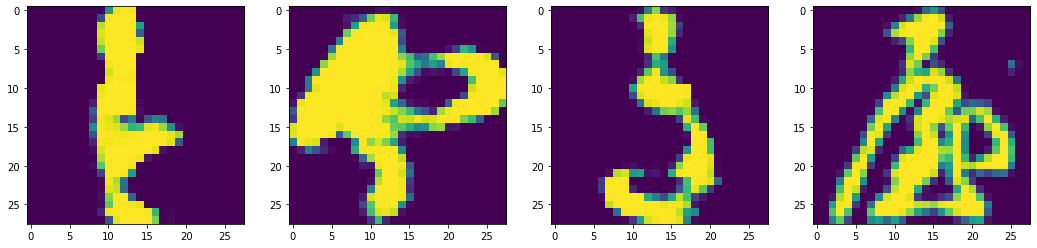

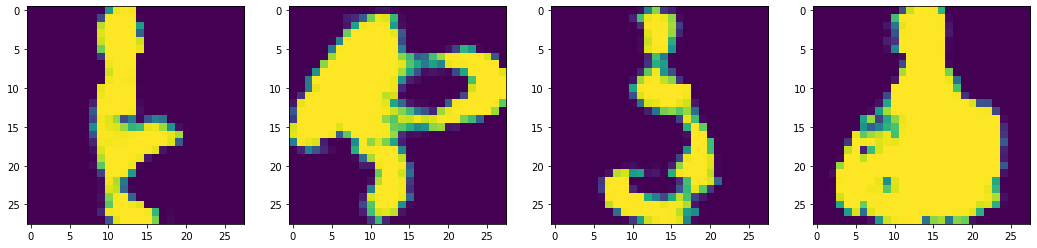

In [12]:
# run image reconstruction test on trained ae_model

with torch.no_grad():
  ae_model.eval()
  test_loss = 0

  for X, y in iter(k_testloader):
    X = X.to(device)
    X_encoded, X_hat = ae_model(X)
    loss = mse_loss(X_hat, X)
    test_loss += loss.item()

  test_loss /= len(k_testloader.dataset)
  print("Test set loss:" + str(test_loss))
  display_images(X, X_hat)

We save the state dictionary of our model to a file as we will make use of the 
pre-trained weights obtained in previous steps as a basis for further steps as a classification task by means of the 'Transfer Learning' technique.

In [13]:
torch.save(ae_model.state_dict(), "kmnist_ae.pt")

Next, we load our already trained model with the aim of fine-tuning it for the desired classification task: to do so, we switch off training for all the layers of the former AE model as we want to have them all freezed, except for the classification head that we are going to add in the next cell. 

In [14]:
# load ae params, freeze the parameters (gradients not computed)

# load parameters of KMinst's training
ae_model.load_state_dict(torch.load("kmnist_ae.pt", map_location=torch.device(device)))

# turn off layers of autoencoder
for name, param in ae_model.named_parameters():
  param.requires_grad = False
  print(name, param.requires_grad)

encoder.0.weight False
encoder.0.bias False
encoder.4.weight False
encoder.4.bias False
encoder.8.weight False
encoder.8.bias False
decoder.0.weight False
decoder.0.bias False
decoder.3.weight False
decoder.3.bias False
decoder.5.weight False
decoder.5.bias False


Then, we set up a new classification model which starts from the freezed encoder's weights we have loaded, and adds on top of them a classification head (i.e. a fully connected layer) where the input corresponds to the $d$ latent dimensions previously obtained (in_features=d) by the encoder, while the length of the output is equal to the 10 classes to whom the Kanji characters belong (out_features=10). Finally we print out the resulting model to allow for a visual inspection of its final structure. 

In [15]:
# setup Fully Connected Layer (Classification Head) class on top of encoder

n_output = 10 # output classes for kmnist classifier

# create a new "head"
classification_head = torch.nn.Sequential(torch.nn.Linear(in_features=d,
                                                          out_features=n_output))

# combine freezed encoder with classification head
ch_model = torch.nn.Sequential(ae_model.encoder,
                               classification_head)
# check final structure
print(ch_model)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=2304, out_features=17, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=17, out_features=10, bias=True)
  )
)


As already done before for AE, we define the rest of the other necessary elements to proceed further with the training of the classification head:  
* the loss function: we use the Cross Entropy Loss (details at https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), a de facto standard for evaluating the performance of training on a classification problem with C classes (C=10 in our case).
* the optimizer: we set again for the Adam algorithm as done before, with the minor difference of a slightly higher learning rate parameter (lr=0.01).
* the number of epochs for the training: after having tried many different lengths, we set for 20 epochs as it seemed enough to obtain a reasonable level of accuracy for our classification (i.e. about 60%).

In [16]:
# initialize model, optimizer, loss, epochs for our classification model

ch_model = ch_model.to(device) # load model to the GPU
ch_optimizer = torch.optim.Adam(ch_model.parameters(), lr=1e-2)
ce_loss = torch.nn.CrossEntropyLoss() # CE as loss
n_epochs_classification = 20

We define a simple function to measure the accuracy of our classification model as a % of correct classifications on all cases tried.

In [17]:
# define a function to calculate accuracy of our classification

def get_accuracy(model, dataloader):
  model.eval()
  with torch.no_grad():
    correct = 0
    for X, y in iter(dataloader):
      X = X.to(device)
      y_predicted = model(X)
      correct += (torch.argmax(y_predicted, axis=1)==y.to(device)).sum()
    return correct / len(dataloader.dataset)

As usual, we define an iterative training function which loops over data, with a first forward pass leading to a first guess of the output (i.e. y_predicted), followed by the calculation of the loss and the cancellation of past gradients and their re-calculation by means of a backward step, so to result in an update of model's parameters (Θ) and the accuracy level reached by each epoch. 

In [18]:
# define a training function for a classification head

def ch_train(model, optimizer, loss_fn, trainloader, testloader, epochs):
  for epoch in range(epochs):
    print("Test accuracy: ", get_accuracy(model, testloader))
    model.train()
    print("Epoch: ", epoch)

    for X, y in iter(trainloader):
      X = X.to(device)
      y_predicted = model(X)
      loss = loss_fn(y_predicted, y.to(device))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  print("Final accuracy: ", get_accuracy(model, testloader))

Here we simply launch the training of our classification model on the predefined number of epochs, stopping the training when a reasonable level of accuracy is attained for our model.

In [19]:
# launch our classification model training and testing

test_accuracy = ch_train(ch_model, ch_optimizer, ce_loss, k_trainloader, k_testloader, n_epochs_classification) # final accuracy about 62%

Test accuracy:  tensor(0.1042, device='cuda:0')
Epoch:  0
Test accuracy:  tensor(0.5754, device='cuda:0')
Epoch:  1
Test accuracy:  tensor(0.5932, device='cuda:0')
Epoch:  2
Test accuracy:  tensor(0.5937, device='cuda:0')
Epoch:  3
Test accuracy:  tensor(0.6019, device='cuda:0')
Epoch:  4
Test accuracy:  tensor(0.6080, device='cuda:0')
Epoch:  5
Test accuracy:  tensor(0.6017, device='cuda:0')
Epoch:  6
Test accuracy:  tensor(0.5855, device='cuda:0')
Epoch:  7
Test accuracy:  tensor(0.6022, device='cuda:0')
Epoch:  8
Test accuracy:  tensor(0.5951, device='cuda:0')
Epoch:  9
Test accuracy:  tensor(0.6068, device='cuda:0')
Epoch:  10
Test accuracy:  tensor(0.6051, device='cuda:0')
Epoch:  11
Test accuracy:  tensor(0.6099, device='cuda:0')
Epoch:  12
Test accuracy:  tensor(0.6061, device='cuda:0')
Epoch:  13
Test accuracy:  tensor(0.6033, device='cuda:0')
Epoch:  14
Test accuracy:  tensor(0.5966, device='cuda:0')
Epoch:  15
Test accuracy:  tensor(0.6074, device='cuda:0')
Epoch:  16
Test ac

Here we define a function to help us creating a visualization of autoencoder's internal representations, via a first t-SNE dimensionality reduction on top of Encoder layer's output. Loosely based on the source code @https://github.com/ncampost/vis-autoencoder-tsne, the function allows for plotting the obtained t-SNE dimensions both on a 2D and on a 3D representation (see plots below).





In [20]:
# define a function to reduce dimensionality from d to 2 or 3 and plot data

def plot_TSNE_dimensions(x_train_encoded, y_train, is_3D):
  '''function to visualize 2D or 3D representations of t-SNE reduced data'''  
  cmap = plt.get_cmap('rainbow', n_output)
  
  if is_3D:
    x_train_encoded = TSNE(n_components=3, random_state=seed).fit_transform(X_encoded.cpu().numpy())
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    p = ax.scatter3D(x_train_encoded[:,0], x_train_encoded[:,1], x_train_encoded[:,2], c=y_train[:], cmap=cmap, edgecolor='black')
    fig.colorbar(p, drawedges=True)
  else:
    x_train_encoded = TSNE(n_components=2, random_state=seed).fit_transform(X_encoded.cpu().numpy())
    plt.scatter(x_train_encoded[:,0], x_train_encoded[:,1], c=y_train[:], edgecolor='black', cmap=cmap)
    plt.colorbar(drawedges=True)

  return plt.show()

Here we run the previously defined function on the output obtained applying first our Encoder layer on the available training data: we obtain 2 plots based on the t-SNE reduced data, where the aim is to identify the 10 clusters of data which we may ideally map into the 10 different classes composing the Kmnist dataset.

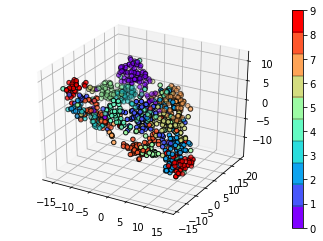

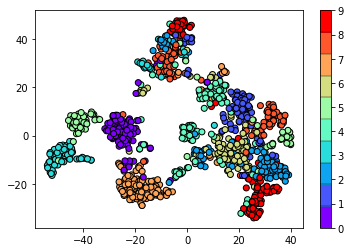

In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

ae_model.load_state_dict(torch.load("kmnist_ae.pt", map_location=torch.device(device)))

with torch.no_grad():
  ae_model.eval()
  for X, y in iter(k_trainloader):
    X = X.to(device)
    X_encoded, X_hat = ae_model(X)

plot_TSNE_dimensions(X_encoded, y, 1)
plot_TSNE_dimensions(X_encoded, y, 0)

We may recognize quite easily some of the clusters, for the most part along the 2D plot, as on the 3D plot it is more difficult to identify them. It would be an interesting experiment to try out different structures for our AutoEncoder to see if varying its elements such as for instance the number of layers, filters' dimensions, kernels' size, padding, regularization techniques applied etc.. would lead to a more neat separation of the treated data over the space dimensions (e.g. as done for the classical Minst dataset in https://arxiv.org/pdf/1802.00187.pdf).